<font size=6><b> AutoML - pycaret (Bike Sharing Demand)

* ref : https://pycaret.readthedocs.io/en/latest/api/regression.html?highlight=regression#module-pycaret.regression
* ref : https://github.com/pycaret/pycaret/blob/master/examples/Pima%20Model.ipynb
* rer : https://pycaret.gitbook.io/docs/learn-pycaret/examples<br>
* ref : https://www.kaggle.com/competitions/bike-sharing-demand/overview

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings(action='ignore')
sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

In [2]:
# ------------------- 관리자 권한 실행 필요 -----------------------
# ! pip install pycaret

In [3]:
from sklearn.model_selection import train_test_split
from pycaret.regression import *


# Data load

In [4]:
train_df  = pd.read_csv("./train.csv" , sep=",",parse_dates=['datetime'])
test_df   = pd.read_csv("./test.csv" , sep="," ,parse_dates=['datetime'])
submit_df = pd.read_csv("./sampleSubmission.csv" , sep=",")

# 전처리 가공

## 날짜처리

In [5]:
for df in [train_df, test_df]:
    df['yy']   = df['datetime'].dt.year
    df['mm']   = df['datetime'].dt.month
    df['dd']   = df['datetime'].dt.day
    df['hh']   = df['datetime'].dt.hour
    df['week'] = df['datetime'].dt.weekday    #5, 6 :주말
    df['dow']  = df['datetime'].dt.dayofweek  #주수
    df.drop("datetime", axis=1, inplace=True)

In [6]:
train_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,yy,mm,dd,hh,week,dow
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5,5


## 풍속 채우기

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
print(train_df[train_df['windspeed'] == 0]['windspeed'].value_counts())

0.0    1313
Name: windspeed, dtype: int64


In [9]:
for df in [train_df, test_df]:  
    col_list = ['season', 'weather', 'atemp', 'humidity', 'yy', 'mm', 'dd', 'hh']

    windspped_X_train = df[df['windspeed'] != .0][col_list]        #--9573 .. ~windspped
    windspped_y_train = df[df['windspeed'] != .0]['windspeed']     #--9573 ..  windspped
    windspped_X_test  = df[df['windspeed'] == .0][col_list] 
    # windspped_y_test  = pred
    print(windspped_y_train.shape, windspped_X_train.shape)
    windspped_X_train.head()

    windspped_model = RandomForestRegressor(n_estimators=100, random_state=1234)
    windspped_model.fit(windspped_X_train, windspped_y_train)
    windspped_pred = windspped_model.predict(windspped_X_test)           #--1313문제
    print(windspped_pred[:5],  windspped_pred.shape)                     #--1313 예측답안갯수

    #--15199건에 해당하는 0값을 windspped값을 pred    -->   windspped_y_test로 대체
    df.loc[df['windspeed'] == .0 , 'windspeed'] = windspped_pred.reshape(-1,1)

(9573,) (9573, 8)
[12.280966 10.20142   9.401373 10.861102 10.171404] (1313,)
(5626,) (5626, 8)
[17.211161 14.480576 10.909677 14.190734 25.129556] (867,)


In [10]:
print(train_df[train_df['windspeed'] == 0]['windspeed'].value_counts())

Series([], Name: windspeed, dtype: int64)


# EDA

In [11]:
# C++ compiler , graphviz 사전 설치 후 설치
# ! pip install pandas-profiling

In [12]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(train_df)
# profile.to_file("eda.html")

# train test 분리

In [13]:
train_df.drop(['casual', 'registered'], axis=1, inplace=True)

In [14]:
train2 = train_df.sample(frac=0.8, random_state=1234)
test2 = train_df.drop(train2.index)
print( train2.shape, test2.shape )

train2 = train2.reset_index(drop=True)
test2  = test2.reset_index(drop=True)
test2.head(2)

(8709, 15) (2177, 15)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,yy,mm,dd,hh,week,dow
0,1,0,0,1,9.84,14.395,75,10.861102,13,2011,1,1,3,5,5
1,1,0,0,1,8.20,12.880,86,10.310965,3,2011,1,1,7,5,5


In [15]:
train, test = train_test_split(train_df, test_size = 0.2, random_state=1234)
print(train.shape, test.shape)
train.head(2)

(8708, 15) (2178, 15)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,yy,mm,dd,hh,week,dow
1180,1,0,0,1,12.30,14.395,56,16.9979,58,2011,3,13,21,6,6
8503,3,0,0,1,35.26,39.395,41,15.0013,495,2012,7,15,16,6,6


# AutoML : pycaret

In [16]:
from pycaret.regression import *

In [17]:
setup_data = setup(train, target = 'count', session_id=1234, log_experiment=True, verbose=True, fold=2)

,Description,Value
0,session_id,1234
1,Target,count
2,Original Data,"(8708, 15)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,9
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6095, 54)"


## 모델 비교

In [18]:
model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,27.6820,1856.3491,43.0763,0.9431,0.4772,0.5247,1.5300
lightgbm,Light Gradient Boosting Machine,28.7345,2086.4408,45.5856,0.9360,0.4418,0.4585,0.1750
xgboost,Extreme Gradient Boosting,30.6760,2274.1737,47.6625,0.9303,0.4877,0.5008,0.5100
et,Extra Trees Regressor,32.0591,2508.8009,50.0749,0.9231,0.4066,0.4305,1.2250
rf,Random Forest Regressor,33.2572,2805.9713,52.8942,0.9139,0.4023,0.3957,0.8500
gbr,Gradient Boosting Regressor,48.2648,5029.7497,70.9200,0.8459,0.6831,0.9465,0.3950
dt,Decision Tree Regressor,44.2269,5666.1756,75.2546,0.8265,0.5062,0.4487,0.0900
ada,AdaBoost Regressor,93.2942,12745.7432,112.8570,0.6098,1.1200,3.0700,0.3150
knn,K Neighbors Regressor,91.5527,17350.1050,131.7149,0.4683,0.9565,2.0157,0.1400
lasso,Lasso Regression,105.7785,19965.4478,141.2960,0.3884,1.2136,3.4087,1.5300


## 모델 선택

In [19]:
# Random Forest Regressor
rf_model = create_model("rf")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32.2548,2503.4148,50.0341,0.9244,0.4124,0.4091
1,34.2596,3108.5278,55.7542,0.9034,0.3921,0.3823
Mean,33.2572,2805.9713,52.8942,0.9139,0.4023,0.3957
Std,1.0024,302.5565,2.8600,0.0105,0.0102,0.0134


In [20]:
# Gradient Boosting Regressor
gbr_model = create_model("gbr")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,48.6988,4984.2927,70.5995,0.8494,0.6840,0.9878
1,47.8309,5075.2067,71.2405,0.8424,0.6821,0.9053
Mean,48.2648,5029.7497,70.9200,0.8459,0.6831,0.9465
Std,0.4340,45.4570,0.3205,0.0035,0.0009,0.0412


## 모델 튜닝

In [21]:
tune_rf_model  = tune_model(rf_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,80.2121,12834.0202,113.2873,0.6123,0.9895,2.2424
1,81.7189,12807.6943,113.1711,0.6022,0.9998,2.3119
Mean,80.9655,12820.8572,113.2292,0.6072,0.9947,2.2771
Std,0.7534,13.1629,0.0581,0.0050,0.0051,0.0347


In [22]:
tune_gbr_model = tune_model(gbr_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,46.2711,4271.2572,65.3549,0.8710,0.7254,1.0886
1,45.8923,4282.9527,65.4443,0.8670,0.7511,1.1588
Mean,46.0817,4277.1050,65.3996,0.8690,0.7382,1.1237
Std,0.1894,5.8478,0.0447,0.0020,0.0128,0.0351


## 모델 성능 차트

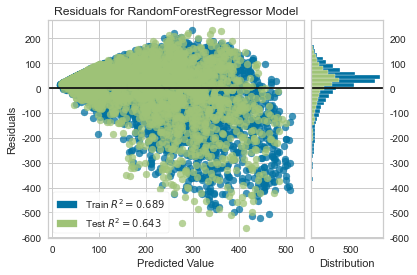

In [23]:
plot_model(tune_rf_model)

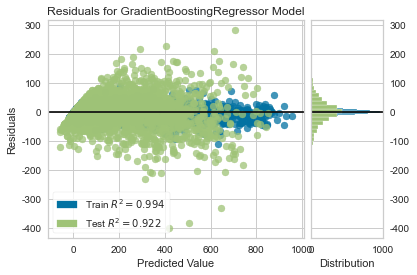

In [24]:
plot_model(tune_gbr_model)

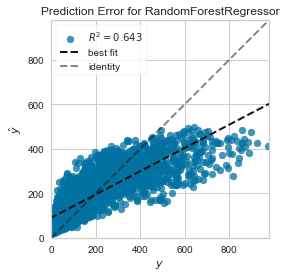

In [25]:
plot_model(tune_rf_model, plot="error")

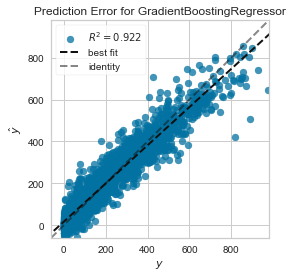

In [26]:
plot_model(tune_gbr_model, plot="error")

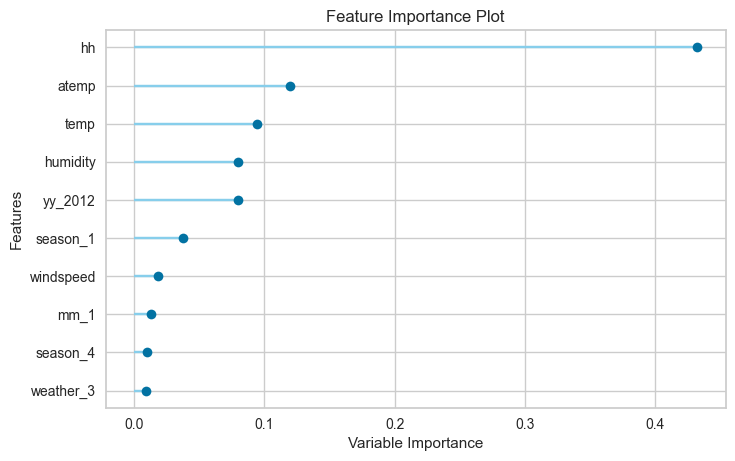

In [27]:
plot_model(tune_rf_model, plot="feature")

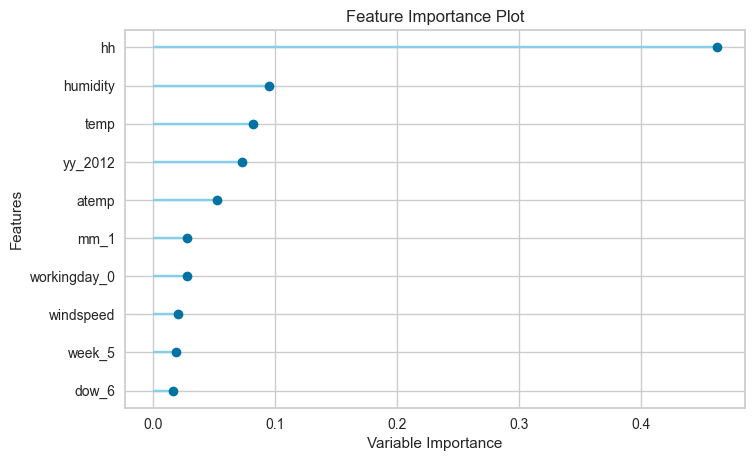

In [28]:
plot_model(tune_gbr_model, plot="feature")

# 평가

In [29]:
evaluate_model(tune_rf_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [30]:
evaluate_model(tune_gbr_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# 예측

In [31]:
rf_res = predict_model(tune_rf_model)
rf_pred = rf_res["Label"]
rf_pred[:5]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,77.5781,11996.8586,109.5302,0.6433,0.9582,2.0777


0     27.092323
1    414.283649
2    271.978248
3    283.484268
4     78.328422
Name: Label, dtype: float64

In [32]:
gbr_res = predict_model(tune_gbr_model)
gbr_pred = gbr_res["Label"]
gbr_pred[:5]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,35.7006,2636.7789,51.3496,0.9216,0.6427,0.8396


0     -1.484895
1    463.249634
2    182.905409
3    244.500437
4     32.623303
Name: Label, dtype: float64

# Voting

In [33]:
# 17*0.2 + 7*0.8

In [34]:
voting_model = blend_models([tune_rf_model, tune_gbr_model])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,55.2424,6459.5838,80.3715,0.8048,0.7586,1.2811
1,56.6605,6449.8365,80.3109,0.7997,0.7864,1.4402
Mean,55.9514,6454.7101,80.3412,0.8023,0.7725,1.3607
Std,0.7091,4.8737,0.0303,0.0026,0.0139,0.0795


In [35]:
vot_res = predict_model(voting_model)
vot_pred = vot_res["Label"]
vot_pred[:5]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,48.6926,5040.4033,70.9958,0.8501,0.7151,1.1665


0     12.803714
1    438.766642
2    227.441828
3    263.992353
4     55.475863
Name: Label, dtype: float64

# 공모전용 : test_df

In [39]:
res = predict_model(voting_model, data=test_df)
pred = res["Label"]
pred[:5]

0    25.457301
1    10.830920
2     5.226464
3    12.748359
4    11.760868
Name: Label, dtype: float64

# Make submission

In [40]:
submit_df = pd.read_csv("./sampleSubmission.csv" , sep=",")

In [41]:
submit_df.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [43]:
len(pred), submit_df.shape

(6493, (6493, 2))

In [46]:
submit_df["count"] = np.abs(pred)
submit_df.head()

,datetime,count
0,2011-01-20 00:00:00,25.457301
1,2011-01-20 01:00:00,10.830920
2,2011-01-20 02:00:00,5.226464
3,2011-01-20 03:00:00,12.748359
4,2011-01-20 04:00:00,11.760868


In [47]:
submit_df.to_csv("pycaret.csv", index=False)